# Product prices analysis

In [1]:
from bs4 import BeautifulSoup as bs
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import plotly.express as px
import descartes
import re
from datetime import datetime
import calmap


from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
import re
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType


In [2]:

def init_spark(app_name, master_config):
    """
    :params app_name: Name of the app
    :params master_config: eg. local[4]
    :returns SparkContext, SQLContext, SparkSession:
    """
    conf = (SparkConf().setAppName(app_name).setMaster(master_config))

    sc = SparkContext(conf=conf)
    sc.setLogLevel("ERROR")
    sql_ctx = SQLContext(sc)
    spark = SparkSession(sc)

    return (sc, sql_ctx, spark)

In [3]:
sc, sql_ctx, spark = init_spark("App_name", "local[4]")

In [4]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.read.option("header", "true").csv("../data/cat_csv/*.csv")
df.count()

2805212

In [5]:
def processCountries(country):
    # Remove html tags
    cleanr = re.compile('<.*?>')
    cleanText = str(re.sub(cleanr, '', str(country)))
    
    # Remove spaces
    cleanText = cleanText.strip(' ')
    
    # Remove ""
    cleanText = cleanText.strip('"')
    
    # Split for each country
    cleanText = re.split("&|,|/", cleanText)
    
    # Top Names reformat
    cleanText = [re.sub(r'^(eu|europeanunion|euonly|europeuniononly|onlytoeurope|europeancountries|westerneurope|ukandeuonly|franceandeu)$', r'europe', w) for w in cleanText]
    cleanText = [re.sub(r'^(everywhere|world|international|anywhere|worlwide|worldwideonrequest|ww|wordwide|global|worldwideinternational|wideworld|all|worldwidepriortracking|wordlwide|worldwideprior|worldwideprior|internationalworldwide|universe|everywhereworldwideanydestination|wolrdwide|wwshipping|freeworldwide|universal|woldwide|worldwideincludingaustralia|worldwidepriorthefastest|internationally)$', r'worldwide', w) for w in cleanText]
    cleanText = [re.sub(r'^(usaonly|unitedstates|us|unitedstatesofamerica|usonly|unitedstatesonly)$', r'usa', w) for w in cleanText]
    cleanText = [re.sub(r'^(unitedkingdom|ukonly)$', r'uk', w) for w in cleanText]
    return cleanText

udf_func_C = udf(processCountries, ArrayType(StringType()))

def processCatHashs(cat_hash):
    # Remove html end of files
    cleanr = re.compile('.\d*.html')
    cleanText = str(re.sub(cleanr, '', str(cat_hash)))
    return cleanText

udf_func_H = udf(processCatHashs, StringType())

# Remove rows without a valid date, error during parsing, file not complete
df = df.filter(df["date"].rlike("\d\d\d\d-\d\d-\d\d"))

# Remove rows without a price or not decimal, 642 in total, mainly due to error during parsing.
df = df.filter("CAST(price AS DECIMAL) is not null")

# Remove the rows where name is null, all the columns are usually null in this case, (6 rows)
df = df.filter("name is not null")

# Lowercase and process the countries
df=df.withColumn("to", lower(col("to")))
df=df.withColumn("to", udf_func_C(col("to")))

# Lowercase and process the countries
df=df.withColumn("from", lower(col("from")))
df=df.withColumn("from", udf_func_C(col("from")))

# Process the hashs
df=df.withColumn("cat_hash", udf_func_H(col("cat_hash")))

## DF Imported and cleaned at this point

In [6]:
type(df)

pyspark.sql.dataframe.DataFrame

In [7]:
df

DataFrame[_c0: string, name: string, price: string, from: array<string>, to: array<string>, vendor: string, cat_hash: string, cat: string, date: string]

In [8]:
df = df.drop('from').drop('to')

In [9]:
df.select("price").distinct().show()

+-----------+
|      price|
+-----------+
| 0.60469965|
| 1.39947068|
| 0.14000000|
| 0.45606694|
| 5.22875816|
| 0.42322415|
| 0.15079027|
|42.48810333|
| 0.07833000|
| 0.13524424|
| 0.37949132|
| 4.13361169|
| 2.83741127|
| 3.99900000|
| 0.63025210|
| 0.88235294|
| 2.21105527|
| 0.42446623|
| 1.23376092|
| 0.21027362|
+-----------+
only showing top 20 rows



In [10]:
df = df.withColumn("price", df["price"].cast("double"))

In [11]:
df

DataFrame[_c0: string, name: string, price: double, vendor: string, cat_hash: string, cat: string, date: string]

In [12]:
from pyspark.sql import functions as F
dfAvgBTCprice = df.groupBy("date").agg(F.mean('price'),F.count('name'))

In [13]:
dfAvgBTCprice.show()

+----------+------------------+-----------+
|      date|        avg(price)|count(name)|
+----------+------------------+-----------+
|2015-05-01| 1.118939097333333|         60|
|2015-02-09| 7.461132928475234|      19862|
|2015-02-28| 5.705755596473382|      20899|
|2015-02-26| 5.577399104618678|      20842|
|2014-11-01|25.936342161298292|      18676|
|2014-10-23|1.9529272582956299|       1326|
|2015-01-21| 9.376179547982483|      19345|
|2015-01-18| 8.319188846327151|      15544|
|2015-03-29| 4.174474557085601|      24324|
|2014-09-26| 40.27707280161736|       8721|
|2015-02-24| 5.665968588287313|      20119|
|2014-12-28|21.056388786063177|      18143|
|2014-07-30|1.0348169139137124|        649|
|2015-02-03|6.1649180697743695|      20379|
|2015-06-22|11.317011846595046|      22744|
|2014-01-09| 1.022030795518377|       1823|
|2014-02-15|0.6631877627848093|        474|
|2014-05-24|298.15064259475895|      11894|
|2014-11-27| 8.408431917253823|       3321|
|2015-01-10| 7.642211204411633| 

In [14]:
pdAvgPriceDF = dfAvgBTCprice.toPandas()

In [15]:
pdAvgPriceDF = pdAvgPriceDF.rename(columns={"date": "date", "avg(price)": "avgPrice(BTC)", "count(name)":"nbOfProducts"})

In [16]:
pdAvgPriceDF.head(20)

,date,avgPrice(BTC),nbOfProducts
0,2015-05-01,1.118939,60
1,2015-02-09,7.461133,19862
2,2015-02-28,5.705756,20899
3,2015-02-26,5.577399,20842
4,2014-11-01,25.936342,18676
5,2014-10-23,1.952927,1326
6,2015-01-21,9.376180,19345
7,2015-01-18,8.319189,15544
8,2015-03-29,4.174475,24324
9,2014-09-26,40.277073,8721


In [17]:
pdAvgPriceDF.dtypes

date              object
avgPrice(BTC)    float64
nbOfProducts       int64
dtype: object

### Load BTC prices

In [18]:
btcPriceDF= pd.read_csv("../data/bitcoin_csv.csv",usecols=['date', 'price(USD)'])

In [19]:
btcPriceDF = btcPriceDF.dropna()
btcPriceDF = btcPriceDF.rename(columns ={'price(USD)':'price'})

In [20]:
btcPriceDF

,date,price
1570,2013-04-28,135.30
1571,2013-04-29,134.44
1572,2013-04-30,144.00
1573,2013-05-01,139.00
1574,2013-05-02,116.38
...,...,...
3600,2018-11-18,5559.74
3601,2018-11-19,5620.78
3602,2018-11-20,4863.93
3603,2018-11-21,4465.54


In [21]:
import datetime as dt

In [22]:
def convertDates(s):
    return dt.datetime.strptime(s, '%b %d, %Y')

In [23]:
def convertDatesAVGPrice(s):
    return dt.datetime.strptime(s, '%Y-%m-%d')

In [24]:
btcPriceDF.date = btcPriceDF.date.apply(convertDatesAVGPrice)

In [25]:
btcPriceDF.dtypes

date     datetime64[ns]
price           float64
dtype: object

In [26]:
btcPriceDF = btcPriceDF.set_index('date')

In [27]:
btcPriceDF

,price
date,
2013-04-28,135.30
2013-04-29,134.44
2013-04-30,144.00
2013-05-01,139.00
2013-05-02,116.38
...,...
2018-11-18,5559.74
2018-11-19,5620.78
2018-11-20,4863.93


In [28]:
pdAvgPriceDF.date = pdAvgPriceDF.date.apply(convertDatesAVGPrice)

In [29]:
pdAvgPriceDF

,date,avgPrice(BTC),nbOfProducts
0,2015-05-01,1.118939,60
1,2015-02-09,7.461133,19862
2,2015-02-28,5.705756,20899
3,2015-02-26,5.577399,20842
4,2014-11-01,25.936342,18676
...,...,...,...
196,2015-02-01,6.776815,19248
197,2014-11-23,28.002736,18203
198,2014-06-03,6.883992,3732
199,2014-11-10,27.574715,17636


In [30]:
def convertBTC(entry):
    date = entry.date
    btcPrice = btcPriceDF.price[date]
    entry['avgPrice(dollars)'] = entry['avgPrice(BTC)'] *btcPrice
    return entry

In [31]:
pdAvgPriceDF = pdAvgPriceDF.apply(convertBTC, axis=1)

In [32]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

def plotNDate(x, y, interval, title, y_label):
    # Prettier plotting with seaborn
    sns.set(font_scale=1.5, style="whitegrid")

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(x,
            y,
            '-o',
            color='purple')
    ax.set(xlabel="Date", ylabel=y_label,
           title=title)
    
    plt.axvline(linewidth=4, color='r', x="2014-11-05", label="Operation Onymous")

    # Format the x axis
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

    # Ensure ticks fall once every other week (interval=2) 
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=interval))
    plt.legend()
    plt.show()

In [33]:
pdAvgPriceDF = pdAvgPriceDF.set_index('date')


In [34]:
# clean outliers en mode cochon
pdAvgPriceDF = pdAvgPriceDF[pdAvgPriceDF['avgPrice(dollars)'] < 25000]

In [35]:
pdAvgPriceDF = pdAvgPriceDF.sort_index()

In [36]:
pdAvgPriceDF.index

DatetimeIndex(['2014-01-01', '2014-01-09', '2014-01-16', '2014-01-26',
               '2014-02-02', '2014-02-05', '2014-02-10', '2014-02-15',
               '2014-02-18', '2014-02-23',
               ...
               '2015-06-13', '2015-06-15', '2015-06-20', '2015-06-22',
               '2015-06-26', '2015-06-28', '2015-06-30', '2015-07-01',
               '2015-07-04', '2015-07-07'],
              dtype='datetime64[ns]', name='date', length=196, freq=None)

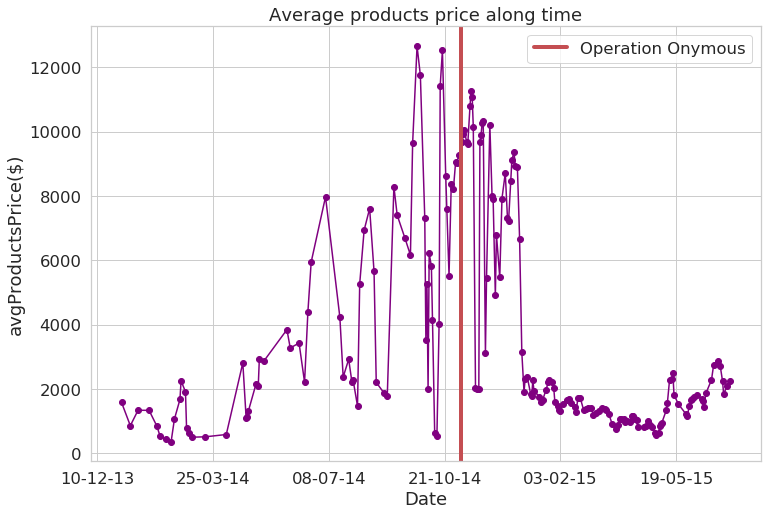

In [74]:
plotNDate(pdAvgPriceDF.index,pdAvgPriceDF['avgPrice(dollars)'], 15 ,'Average products price along time','avgProductsPrice($)')

## Trying to clean data 

In [38]:
dateSerie = pdAvgPriceDF.index.to_series()
dateSerie = dateSerie.reset_index(drop=True)

In [39]:
dateSerie

0     2014-01-01
1     2014-01-09
2     2014-01-16
3     2014-01-26
4     2014-02-02
         ...    
191   2015-06-28
192   2015-06-30
193   2015-07-01
194   2015-07-04
195   2015-07-07
Name: date, Length: 196, dtype: datetime64[ns]

In [71]:
compressionwidth = 20

In [80]:
def correctoutliers(entry):
    currentDate = entry.name

    ithEntry = dateSerie[dateSerie == currentDate ]

    i = ithEntry.index[0]
    localSubset = pdAvgPriceDF.loc[pdAvgPriceDF.index[i-compressionwidth]:pdAvgPriceDF.index[i+compressionwidth]]
    minQ = localSubset["avgPrice(dollars)"].quantile(0.3)
    maxQ = localSubset["avgPrice(dollars)" ].quantile(0.7)
    avgP = entry['avgPrice(dollars)']
    if(avgP>maxQ or avgP<minQ):
        entry['avgPrice(dollars)'] = localSubset["avgPrice(dollars)"].mean()
    return entry

In [81]:
correctedDF= pdAvgPriceDF.copy()

In [82]:
correctedDF.iloc[compressionwidth:-compressionwidth] = correctedDF.iloc[compressionwidth:-compressionwidth].apply(correctoutliers, axis=1)

In [127]:
def plotNDate2(x,y1, y2, interval, title, y_label1, y_label2):
    # Prettier plotting with seaborn
    sns.set(font_scale=1.5, style="whitegrid")

    fig, ax = plt.subplots(figsize=(12, 8))

    #ax.bar(x,y2,color='grey',width=1,linewidth=0)
    ax.plot(x,y2,color='blue',linestyle='none', marker='.', label=y_label2)

    
    
    ax.set(xlabel="Date", ylabel=y_label2,
           title=title)

    ax2 = ax.twinx()
    
    ax2.set(ylabel=y_label1)
    
    ax2.plot(x, y1,'-', color='purple')
    ax2.plot(btcPriceDF.index.to_series().iloc[:-1000], btcPriceDF['price'].iloc[:-1000],'-', color='orange')
    
    plt.axvline(linewidth=2, color='r', x="2014-11-05", label="Operation Onymous")

    # Format the x axis
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

    # Ensure ticks fall once every other week (interval=2) 
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=interval))
    plt.legend()
    plt.show()

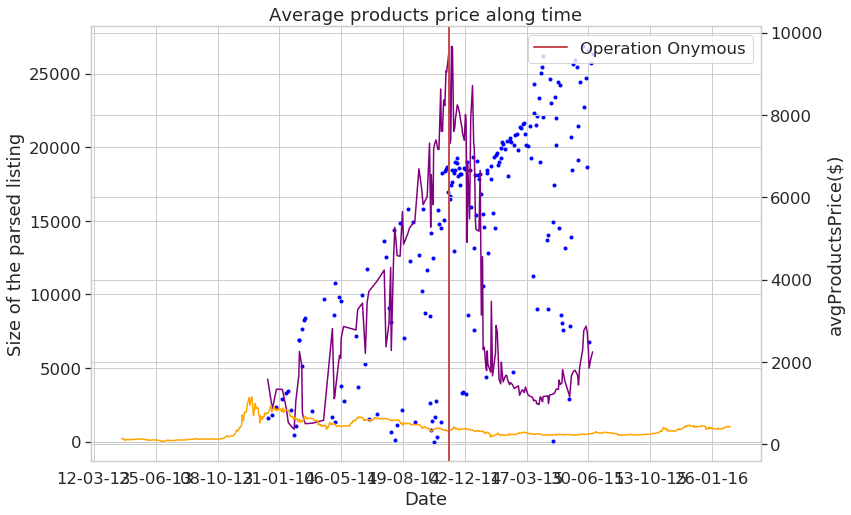

In [128]:
plotNDate2(correctedDF.index,correctedDF['avgPrice(dollars)'],correctedDF['nbOfProducts'], 15 ,'Average products price along time','avgProductsPrice($)','Size of the parsed listing')